In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline


In [2]:
mode='bilinear'
width = 64
base_levels = 1.61803
base_levels = 2

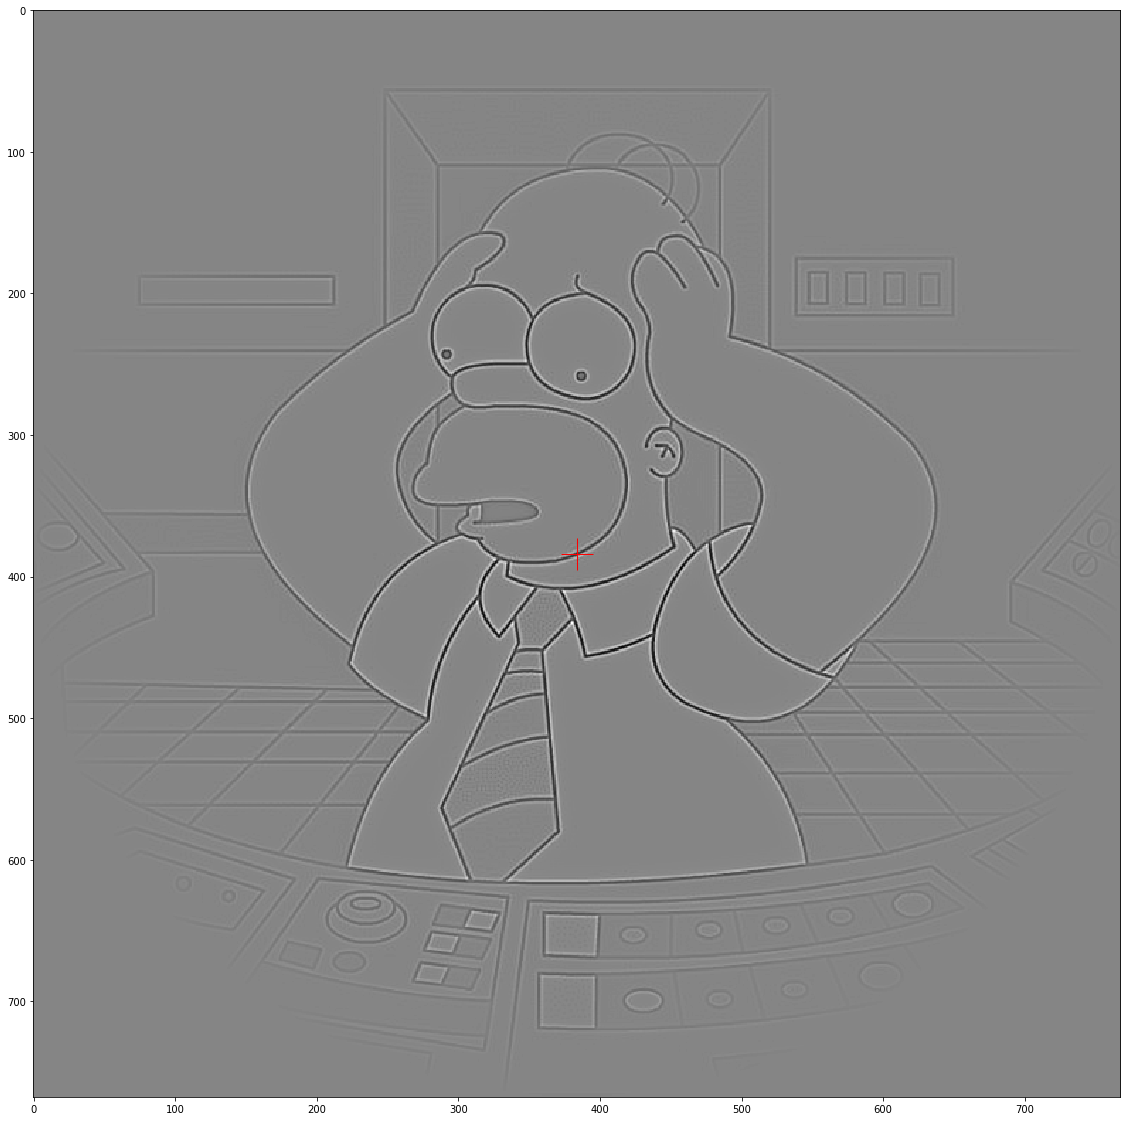

In [3]:
from SLIP import imread
img_orig = imread('../data/homer.jpg')

from SLIP import Image
pe = {'N_X': img_orig.shape[0], 'N_Y': img_orig.shape[1], 'do_mask': True, 'do_whitening': True,
      'white_name_database': 'kodakdb', 'white_n_learning': 0, 'white_N':
          0.07, 'white_N_0': 0.0, 'white_f_0': 0.4, 'white_alpha': 1.4,
      'white_steepness': 4.0, 'white_recompute': False, 'base_levels':
          base_levels, 'n_theta': 24, 'B_sf': 0.4, 'B_theta': 0.17453277777777776,
      'use_cache': True, 'figpath': 'results', 'edgefigpath':
          'results/edges', 'matpath': 'cache_dir', 'edgematpath':
          'cache_dir/edges', 'datapath': 'database/', 'ext': '.pdf', 'figsize':
          14.0, 'formats': ['pdf', 'png', 'jpg'], 'dpi': 450, 'verbose': 0}

im = Image(pe)
img_orig = im.whitening(img_orig) * im.mask

fig, ax = plt.subplots(figsize=(20,20))
ax.imshow(img_orig, cmap='gray')
ax.plot([img_orig.shape[0]/2], [img_orig.shape[1]/2], 'r+', ms=32);

# using torch to build up a pyramid

https://pytorch.org/docs/master/nn.functional.html#torch.nn.functional.interpolate

In [4]:
import torch
img_tens = torch.Tensor(img_orig[None, None, ...])
print('Tensor shape=', img_tens.shape)

Tensor shape= torch.Size([1, 1, 768, 768])


In [5]:
from torch.nn.functional import interpolate
mode='bilinear'
width = 32
base_levels = 1.61803
base_levels = 2

img_down = img_tens
n_levels = 0
while max(img_down.shape) > width :
    img_down = interpolate(img_down, scale_factor=1/base_levels, mode=mode)
    n_levels += 1
    print('Tensor shape=', img_down.shape, ', n_levels=', n_levels)

Tensor shape= torch.Size([1, 1, 384, 384]) , n_levels= 1
Tensor shape= torch.Size([1, 1, 192, 192]) , n_levels= 2
Tensor shape= torch.Size([1, 1, 96, 96]) , n_levels= 3
Tensor shape= torch.Size([1, 1, 48, 48]) , n_levels= 4
Tensor shape= torch.Size([1, 1, 24, 24]) , n_levels= 5


Applying on the central crop of $32\times32$

Tensor shape= torch.Size([1, 5, 32, 32])


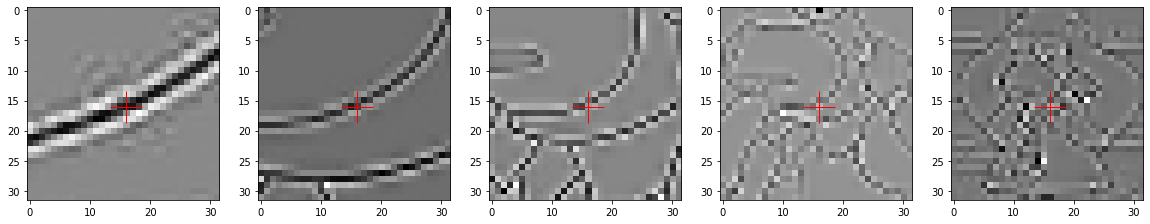

In [6]:
img_tens = torch.Tensor(img_orig[None, None, ...])
img_down = img_tens
img_crop = torch.zeros((1, n_levels, width, width))
fig, axs = plt.subplots(1, n_levels, figsize=(20,20))
for i_level, ax in enumerate(axs):
    img_residual = img_down
    img_down = interpolate(img_down, scale_factor=1/2, mode=mode)
    img_residual -= interpolate(img_down, size=img_residual.shape[-2:], mode=mode)
    
    h_res, w_res = img_residual.shape[-2:]
    img_crop[0, i_level, :, :] = img_residual[:, :, 
                        (h_res//2-width//2):(h_res//2+width//2), 
                        (w_res//2-width//2):(w_res//2+width//2)]
    
    ax.imshow(img_crop.numpy()[0, i_level, ...], cmap='gray')
    ax.plot([width/2], [width/2], 'r+', ms=32);
print('Tensor shape=', img_crop.shape)

## creating a set of filters

In [7]:
from LogGabor import LogGabor
pe = {'N_X': width, 'N_Y': width, 'do_mask': False, 'do_whitening': True,
      'white_name_database': 'kodakdb', 'white_n_learning': 0, 'white_N':
          0.07, 'white_N_0': 0.0, 'white_f_0': 0.4, 'white_alpha': 1.4,
      'white_steepness': 4.0, 'white_recompute': False, 'base_levels':
          base_levels, 'n_theta': 24, 'B_sf': 0.6, 'B_theta': np.pi/12 ,
      'use_cache': True, 'figpath': 'results', 'edgefigpath':
          'results/edges', 'matpath': 'cache_dir', 'edgematpath':
          'cache_dir/edges', 'datapath': 'database/', 'ext': '.pdf', 'figsize':
          14.0, 'formats': ['pdf', 'png', 'jpg'], 'dpi': 450, 'verbose': 0}
lg = LogGabor(pe)
print('lg shape=', lg.pe.N_X, lg.pe.N_Y)

lg shape= 32 32


In [8]:
def local_filter(azimuth, theta, phase, sf_0=.25, radius=width/4):

    x, y = lg.pe.N_X//2, lg.pe.N_Y//2 # center
    x += radius * np.cos(azimuth)
    y += radius * np.sin(azimuth)
    
    return lg.normalize(lg.invert(
        lg.loggabor(x, y, sf_0=sf_0, B_sf=lg.pe.B_sf, theta=theta, B_theta=lg.pe.B_theta) * np.exp(-1j * phase)))

K = local_filter(azimuth=0, theta=0, phase=0, radius=width/4)
print('K shape=', K.shape)
print('K min max=', K.min(), K.max())

K shape= (32, 32)
K min max= -0.4102999708906189 1.0


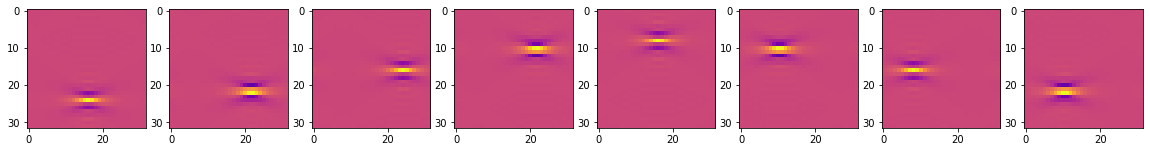

In [9]:
n_test = 8
fig, axs = plt.subplots(1, n_test, figsize=(20,20))
for i_azimuth, ax in enumerate(axs):
    ax.imshow(local_filter(azimuth=i_azimuth*2*np.pi/n_test, 
                           theta=0, phase=0), vmin=-1, vmax=1, cmap='plasma')


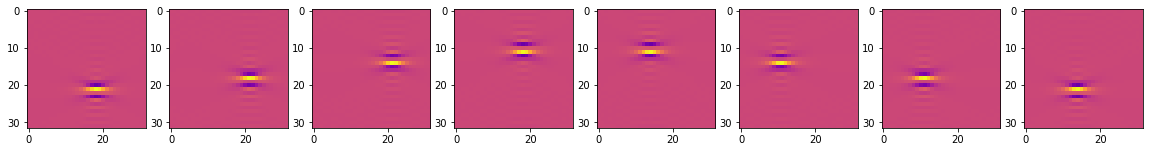

In [10]:
fig, axs = plt.subplots(1, n_test, figsize=(20,20))
for i_azimuth, ax in enumerate(axs):
    ax.imshow(local_filter(azimuth=(i_azimuth+.5)*2*np.pi/n_test, sf_0=.25*np.sqrt(2), 
                           theta=0, phase=0, radius=width/4/np.sqrt(2)), vmin=-1, vmax=1, cmap='plasma')


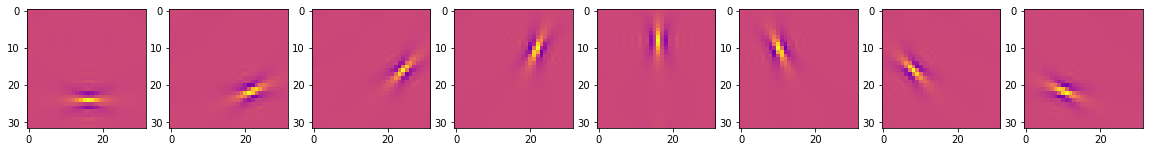

In [11]:
fig, axs = plt.subplots(1, n_test, figsize=(20,20))
for i_azimuth, ax in enumerate(axs):
    ax.imshow(local_filter(azimuth=i_azimuth*2*np.pi/n_test, 
                           theta=i_azimuth*np.pi/n_test, phase=0), vmin=-1, vmax=1, cmap='plasma')


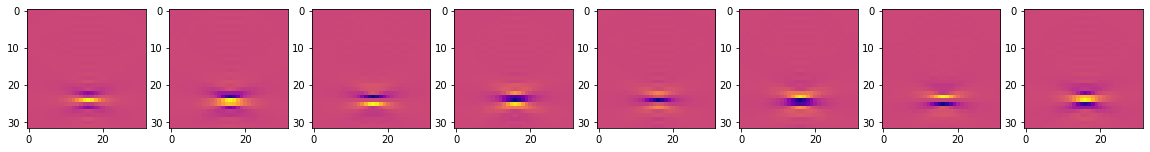

In [12]:
fig, axs = plt.subplots(1, n_test, figsize=(20,20))
for i_phase, ax in enumerate(axs):
    ax.imshow(local_filter(azimuth=0, theta=0, phase=i_phase*2*np.pi/n_test), vmin=-1, vmax=1, cmap='plasma')


In [13]:
n_sublevel = 2
n_azimuth = 12
n_theta = 12
n_phase = 2

K = np.zeros((width, width, n_sublevel, n_azimuth, n_theta, n_phase))
for i_sublevel in range(n_sublevel):
    sf_0 = .25*(np.sqrt(2)**i_sublevel)
    radius = width/4/(np.sqrt(2)**i_sublevel)
    print('i_sublevel, sf_0, radius', i_sublevel, sf_0, radius)
    for i_azimuth in range(n_azimuth):
        for i_theta in range(n_theta):
            for i_phase in range(n_phase):
                K[..., i_sublevel, i_azimuth, i_theta, i_phase] = local_filter(azimuth=(i_azimuth+i_sublevel/2)*2*np.pi/n_azimuth, 
                                                                               theta=i_theta*np.pi/n_theta, 
                                                                               phase=i_phase*np.pi/n_phase, sf_0=sf_0, radius=radius)
print('K shape=', K.shape)
print('K min max=', K.min(), K.max())

i_sublevel, sf_0, radius 0 0.25 8.0
i_sublevel, sf_0, radius 1 0.3535533905932738 5.65685424949238
K shape= (32, 32, 2, 12, 12, 2)
K min max= -1.0 1.0


## applying the filter

In [14]:
K_ = torch.Tensor(K)
print('Tensor shape=', K_.shape)

Tensor shape= torch.Size([32, 32, 2, 12, 12, 2])


In [15]:
print('Tensor shape=', img_crop.shape)

Tensor shape= torch.Size([1, 5, 32, 32])


In [16]:
%%timeit
out = torch.tensordot(img_crop, K_,  dims=2)

44.7 µs ± 723 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [17]:
out = torch.tensordot(img_crop, K_,  dims=2)
print('Tensor shape=', out.shape)

Tensor shape= torch.Size([1, 5, 2, 12, 12, 2])


## reconstruction of cropped central images

### layer by layer

Tensor shape= torch.Size([1, 5, 32, 32])


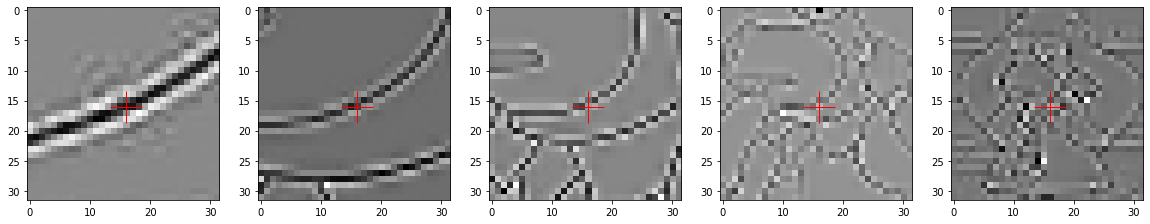

In [18]:
fig, axs = plt.subplots(1, n_levels, figsize=(20,20))
for i_level, ax in enumerate(axs):
    ax.imshow(img_crop.numpy()[0, i_level, ...], cmap='gray')
    ax.plot([width/2], [width/2], 'r+', ms=32);
print('Tensor shape=', img_crop.shape)

In [19]:
print('Tensor shape=', K_.shape)
K__ = K_.reshape((width**2, n_sublevel*n_azimuth*n_theta*n_phase))
print('Tensor shape=', K__.shape)

Tensor shape= torch.Size([32, 32, 2, 12, 12, 2])
Tensor shape= torch.Size([1024, 576])


In [20]:
print('Tensor shape=', out.shape)
out__ = out.reshape((1, n_levels, n_sublevel*n_azimuth*n_theta*n_phase))
print('Tensor shape=', out__.shape)

Tensor shape= torch.Size([1, 5, 2, 12, 12, 2])
Tensor shape= torch.Size([1, 5, 576])


In [21]:
K_inv = torch.pinverse(K__)
print('Tensor shape=', K_inv.shape)

Tensor shape= torch.Size([576, 1024])


In [22]:
img_rec =  torch.tensordot(out__, K_inv,  dims=1).reshape((1, n_levels, width, width))
print('Tensor shape=', img_rec.shape)

Tensor shape= torch.Size([1, 5, 32, 32])


Tensor shape= torch.Size([1, 5, 32, 32])


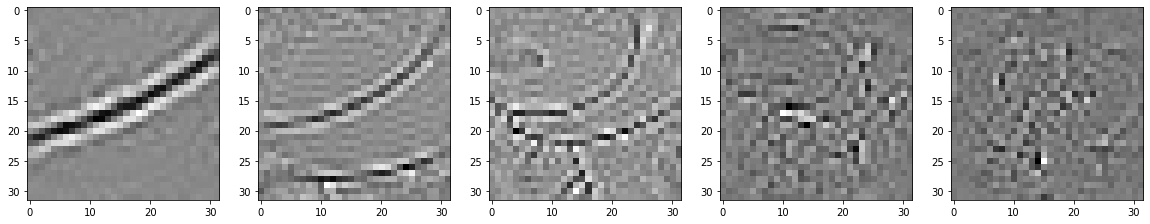

In [23]:
fig, axs = plt.subplots(1, n_levels, figsize=(20,20))
for i_level, ax in enumerate(axs):
    ax.imshow(img_rec.numpy()[0, i_level, ...], cmap='gray')
print('Tensor shape=', img_crop.shape)

In [24]:
img_rec =  torch.tensordot(out__, K__.T,  dims=1).reshape((1, n_levels, width, width))
print('Tensor shape=', img_rec.shape)

Tensor shape= torch.Size([1, 5, 32, 32])


Tensor shape= torch.Size([1, 5, 32, 32])


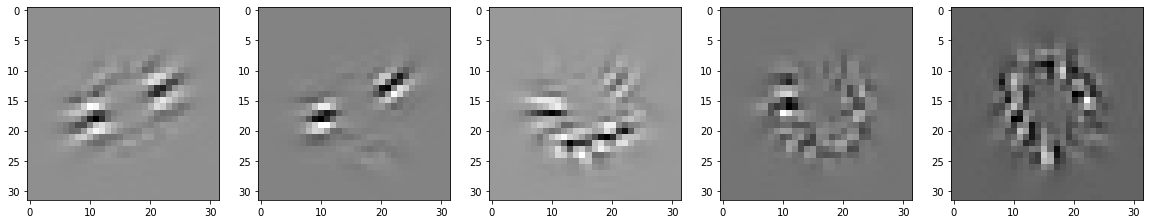

In [25]:
fig, axs = plt.subplots(1, n_levels, figsize=(20,20))
for i_level, ax in enumerate(axs):
    ax.imshow(img_rec.numpy()[0, i_level, ...], cmap='gray')
print('Tensor shape=', img_crop.shape)


### all layers at once ?

Would require learning ...